Basic imports

In [98]:
#@title [RUN] Install required python libraries
import os

# Install PyTorch Geometric and other libraries
if 'IS_GRADESCOPE_ENV' not in os.environ:
    !pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
    !pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
    !pip install -q torch-geometric==2.0.3
    !pip install -q rdkit-pypi==2021.9.4
    !pip install -q py3Dmol==1.8.0

In [117]:
#@title [RUN] Import python modules

import os
import time
import random
import numpy as np

from scipy.stats import ortho_group

import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, BatchNorm1d, Module, Sequential

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import Batch
from torch_geometric.datasets import QM9
import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops, to_dense_adj, dense_to_sparse
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.datasets import QM9
from torch_scatter import scatter

import rdkit.Chem as Chem
from rdkit.Geometry.rdGeometry import Point3D
from rdkit.Chem import QED, Crippen, rdMolDescriptors, rdmolops
from rdkit.Chem.Draw import IPythonConsole

import py3Dmol
from rdkit.Chem import AllChem

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#from google.colab import files
from IPython.display import HTML

print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))

PyTorch version 2.4.1
PyG version 2.0.3


In [118]:
#@title [RUN] Set random seed for deterministic results

def seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed(0)

Functions - may not need

In [119]:
# For storing experimental results over the course of the practical
RESULTS = {}
DF_RESULTS = pd.DataFrame(columns=["Test MAE", "Val MAE", "Epoch", "Model"])

Convert networkx inputs to PyG

In [120]:
import json
import networkx as nx
import copy

def load_data_from_file(filename):
    """
    Load a dictionary of graphs from JSON file.
    """
    with open(filename, "r") as file_handle:
        string_dict = json.load(file_handle)
    return _load_data_from_string_dict(string_dict)

def load_data_from_string(json_string):
    """
    Load a dictionary of graphs from JSON string.
    """
    string_dict = json.loads(json_string)
    return _load_data_from_string_dict(string_dict)

def _load_data_from_string_dict(string_dict):
    result_dict = {}
    for key in string_dict:

        data = copy.deepcopy(string_dict[key])

        if 'edges' in data:
            data["links"] = data.pop("edges")

        graph = nx.node_link_graph(data)
        result_dict[key] = graph
    return result_dict

def write_data_to_json_string(graph_dict, **kwargs):
    """
    Write dictionary of graphs to JSON string.
    """
    json_string = json.dumps(graph_dict, default=nx.node_link_data, **kwargs)
    return json_string


def write_data_to_json_file(graph_dict, filename, **kwargs):
    """
    Write dictionary of graphs to JSON file.
    """
    with open(filename, "w") as file_handle:
        file_handle.write(write_data_to_json_string(graph_dict, **kwargs))

In [121]:
train_data = load_data_from_file("graph_data_duplicates_v2.json") # dictionary of SMILES and values are graphs

In [122]:
atom_dict = {
 'H':1,
 'He':2,
 'Li': 3,
 'B': 5,
 'C': 6,
 'N': 7,
 'O': 8,
 'F': 9,
 'Ne': 10,
 'Na': 11,
 'Mg': 12,
 'Al': 13,
 'Si': 14,
 'P': 15,
 'S': 16,
 'Cl': 17,
 'Ar': 18,
 'K': 19,
 'Ca': 20,
 'Ti': 22,
 'V': 23,
 'Cr': 24,
 'Mn': 25,
 'Fe': 26,
 'Co': 27,
 'Ni': 28,
 'Cu': 29,
 'Zn': 30,
 'Ga': 31,
 'Ge': 32,
 'As': 33,
 'Se': 34,
 'Br': 35,
 'Kr': 36,
 'Rb': 37,
 'Sr': 38,
 'Mo': 42,
 'Rh': 45,
 'Ag': 47,
 'Cd': 48,
 'In': 49,
 'Sn': 50,
 'Sb': 51,
 'Te': 52,
 'I': 53,
 'Xe': 54,
 'Cs': 55,
 'Ba': 56,
 'W': 74,
 'Re': 75,
 'Hg': 80,
 'Tl': 81,
 'Pb': 82,
 'Bi': 83,
 'U': 92
}

orb_dict = {
 '1s': [1, 0, 0],
 '2s': [2, 0, 0],
 '2p': [2, 1, 0],
 '2p3/2': [2, 1, 1.5],
    
 '3s': [3, 0, 0],
 '3p': [3, 1, 0],
 '3p3/2': [3, 1, 1.5],
 '3d': [3, 2, 0],
 '3d5/2': [3, 2, 2.5],
    
 '4s': [4, 0, 0],
 '4p3/2': [4, 1, 1.5],
 '4d': [4, 2, 0],
 '4d5/2': [4, 2, 2.5],
 '4f7/2': [4, 3, 3.5],
    
 '5s': [5, 0, 0],
 '5p3/2': [5, 1, 1.5],
 '5d5/2': [5, 2, 2.5],
}

orb_list = list(orb_dict.keys())

bond_dict = {'SINGLE':1, 'DOUBLE':2, 'TRIPLE':3, 'NONE':0}

In [123]:
import pandas as pd

# Lookup table
iso_be_df = pd.read_csv('Isolated_Energy_final.csv')

# Embeddings
embed_df = pd.read_csv('final_embedding_dim30_one-hot-orbital.csv')

In [124]:
# Embedding IDs
embedded_atoms = list(embed_df['Atoms'])

# Embedding vectors
embed_dict = {}

for i in range(len(embed_df)):
    # Ignore one-hot encoding for orbitals
    vec = np.fromstring(embed_df.loc[i,'Embeddings'].replace('\n','').strip('[]'), sep=' ')[:30] 
    if embedded_atoms[i] not in embed_dict:
        embed_dict[embedded_atoms[i]] = vec
        
# Embedding doesn't have entry for H
embed_dict['H'] = np.zeros(30)

In [125]:
dataset = []

for i, mol in enumerate(train_data):
    graph = train_data[mol]
    
    # Create node features (# atoms by target, atomic embedding, charge, one-hot encoding for orbital)
    targets = list(nx.get_node_attributes(graph, "target").values())
    x = np.zeros((len(targets), 49))

    # Indicate target atom
    atom_index = targets.index(True)
    x[atom_index, 0] = 1  
    
    # Indicate formal charges
    charge = list(nx.get_node_attributes(graph, "formal_charge").values())
    x[:, 1] = charge  
    
    # Indicate atom embeddings
    atom = list(nx.get_node_attributes(graph, "atom_type").values())
    embed_mat = np.array([embed_dict[a] for a in atom])
    x[:,2:32] = embed_mat
    
    # One hot encode orbital for target atom
    orb = list(nx.get_node_attributes(graph, "orbitals").values())
    x[atom_index, 32 + orb_list.index(orb[atom_index][0])] = 1 
    
    # Make PyG friendly
    x = torch.tensor(x, dtype=torch.float)
    
    # Target value
    energy = list(nx.get_node_attributes(graph, "binding_energies").values())
    y = torch.tensor([energy[atom_index][0]], dtype=torch.float)
    # Isolated binding energy from lookup table (for delta learning)
    be = float(iso_be_df.loc[atom_dict[atom[atom_index]]-1,orb[atom_index][0]]) 
    
    # Encode edge indices
    bond_types = list(nx.get_edge_attributes(graph, "bond_type").values())
    
    # Fix for edge_attr construction
    edge_attr = torch.tensor([bond_dict[b] for b in bond_types], dtype=torch.float)
    edge_attr = edge_attr.unsqueeze(1)
    
    # Fix for edge_index construction
    edge_index = torch.tensor(list(graph.edges), dtype=torch.long).t().contiguous()

    # Then proceed with creating the Data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y-be, name=mol, y0=be)
    dataset.append(data)

random.shuffle(dataset)

Data prep and splitting

In [126]:
print(f"Total number of samples: {len(dataset)}.")

# Split datasets (in case of using the full dataset)
# test_dataset = dataset[:10000]
# val_dataset = dataset[10000:20000]
# train_dataset = dataset[20000:]

# Split datasets (our 3K subset)
train_dataset = dataset[:3000]
val_dataset = dataset[3000:4000]
test_dataset = dataset[4000:]
print(f"Created dataset splits with {len(train_dataset)} training, {len(val_dataset)} validation, {len(test_dataset)} test samples.")

# Create dataloaders with batch size = 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Total number of samples: 5192.
Created dataset splits with 3000 training, 1000 validation, 1192 test samples.


### Blueprint of data objects

**Atom features (`data.x`)** - $\mathbb{R}^{|V| \times 11}$
- 1st-5th features: Atom type (one-hot: H, C, N, O, F)
- 6th feature (also `data.z`): Atomic number (number of protons).
- 7th feature: Aromatic (binary)
- 8th-10th features: Electron orbital hybridization (one-hot: sp, sp2, sp3)
- 11th feature: Number of hydrogens

**Edge Index (`data.edge_index`)** - $\mathbb{R}^{2×|E|}$
- A tensor of dimensions 2 x `num_edges` that describe the edge connectivity of the graph

**Edge features (`data.edge_attr`)** - $\mathbb{R}^{|E|\times 4}$
- 1st-4th features: bond type (one-hot: single, double, triple, aromatic)

**Target (`data.y`)** - $\mathbb{R}^{1}$
- A scalar value corresponding to the target electron's binding energy

In [127]:
import torch
import torch.nn as nn
from torch_geometric.nn import GATConv, global_mean_pool

class GATModel(nn.Module):
    def __init__(self,
                 in_dim:    int,
                 emb_dim:   int = 64,
                 num_layers:int = 10,
                 heads:     int = 4,
                 out_dim:   int = 1,
                 edge_dim:  int = 1):
        super().__init__()
        # 1) Initial node feature projection
        self.lin_in = nn.Linear(in_dim, emb_dim)

        # 2) Stack of GATConv layers, now with edge_dim support
        self.convs = nn.ModuleList([
            GATConv(
                in_channels=emb_dim,
                out_channels=emb_dim,
                heads=heads,
                concat=False,    # average heads, keep output dim = emb_dim
                dropout=0.1,
                edge_dim=edge_dim
            )
            for _ in range(num_layers)
        ])

        # 3) Global pooling and final prediction head
        self.pool     = global_mean_pool
        self.lin_pred = nn.Linear(emb_dim, out_dim)

    def forward(self, data):
        # data.x: [total_nodes, in_dim]
        # data.edge_index: [2, num_edges]
        # data.edge_attr: [num_edges, edge_dim]
        # data.batch: [total_nodes] mapping nodes -> graphs

        h = self.lin_in(data.x)  # → [N_nodes, emb_dim]
        for conv in self.convs:
            h_new = conv(h, data.edge_index, data.edge_attr)  # → [N_nodes, emb_dim]
            h     = h + h_new                                  # residual add
        h_graph = self.pool(h, data.batch)                    # → [batch_size, emb_dim]
        out     = self.lin_pred(h_graph)                      # → [batch_size, 1]
        return out.view(-1)                                   # → [batch_size]

Unit tests

In [128]:
def permute_graph(data, perm):
    """Helper function for permuting PyG Data object attributes consistently.
    """
    # Permute the node attribute ordering
    data.x = data.x[perm]
    data.batch = data.batch[perm]

    # Permute the edge index
    adj = to_dense_adj(data.edge_index)
    adj = adj[:, perm, :]
    adj = adj[:, :, perm]
    data.edge_index = dense_to_sparse(adj)[0]

    # Note:
    # (1) While we originally defined the permutation matrix P as only having
    #     entries 0 and 1, its implementation via `perm` uses indexing into
    #     torch tensors, instead.
    # (2) It is cumbersome to permute the edge_attr, so we set it to constant
    #     dummy values. For any experiments beyond unit testing, all GNN models
    #     use the original edge_attr.

    return data

def permutation_invariance_unit_test(module, dataloader):
    """Unit test for checking whether a module (GNN model) is
    permutation invariant.
    """
    it = iter(dataloader)
    data = next(it)

    # Set edge_attr to dummy values (for simplicity)
    data.edge_attr = torch.zeros(data.edge_attr.shape)

    # Forward pass on original example
    out_1 = module(data)

    # Create random permutation
    perm = torch.randperm(data.x.shape[0])
    data = permute_graph(data, perm)

    # Forward pass on permuted example
    out_2 = module(data)

    # Check whether output varies after applying transformations
    return torch.allclose(out_1, out_2, atol=1e-04)


def permutation_equivariance_unit_test(module, dataloader):
    """Unit test for checking whether a module (GNN layer) is
    permutation equivariant.
    """
    it = iter(dataloader)
    data = next(it)

    # Set edge_attr to dummy values (for simplicity)
    data.edge_attr = torch.zeros(data.edge_attr.shape)

    # Forward pass on original example
    out_1 = module(data.x, data.edge_index, data.edge_attr)

    # Create random permutation
    perm = torch.randperm(data.x.shape[0])
    data = permute_graph(data, perm)

    # Forward pass on permuted example
    out_2 = module(data.x, data.edge_index, data.edge_attr)

    # Check whether output varies after applying transformations
    return torch.allclose(out_1[perm], out_2, atol=1e-04)

In [129]:
# Permutation-invariance/equivariance unit tests
from torch_geometric.loader import DataLoader

# Hyperparameters
in_dim  = 49
emb_dim = 64
heads   = 4
edge_dim = 1

# Instantiate layer and model for testing
layer = GATConv(
    in_channels=in_dim,
    out_channels=emb_dim,
    heads=heads,
    concat=False,
    dropout=0.0,
    edge_dim=edge_dim
)

model = GATModel(
    in_dim=in_dim,
    emb_dim=emb_dim,
    num_layers=5,
    heads=heads,
    out_dim=1,
    edge_dim=edge_dim
).eval()  # disable dropout for deterministic behavior

# DataLoader
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Run tests
print(f"Is {type(model).__name__} permutation invariant? --> "
      f"{permutation_invariance_unit_test(model, dataloader)}!")
print(f"Is {type(layer).__name__} permutation equivariant? --> "
      f"{permutation_equivariance_unit_test(layer, dataloader)}!")

Is GATModel permutation invariant? --> True!
Is GATConv permutation equivariant? --> True!


Training and evaluation

In [130]:
import time
import numpy as np
import torch
import torch.nn.functional as F

def train(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0.0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        # model(data) now returns energy = exp(log(y0) + r_pred)
        y_pred = model(data)              # shape: (batch_size,)
        y_true = data.y                   # true energy

        loss = F.mse_loss(y_pred, y_true)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data.num_graphs

    return total_loss / len(train_loader.dataset)


def eval(model, loader, device):
    model.eval()
    total_err = 0.0

    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            y_pred = model(data)          # predicted energy
        y_true = data.y
        total_err += ((y_pred - y_true) ** 2).sum().item()

    return total_err / len(loader.dataset)


def run_experiment(model, model_name,
                   train_loader, val_loader, test_loader,
                   n_epochs=100):

    print(f"Running experiment for {model_name} on {len(train_loader.dataset)} samples.")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.95, patience=5, min_lr=1e-5)

    best_val_err   = float('inf')
    perf_per_epoch = []
    t_start        = time.time()

    for epoch in range(1, n_epochs+1):
        lr        = optimizer.param_groups[0]['lr']
        train_mse = train(model, train_loader, optimizer, device)
        val_mse   = eval(model, val_loader, device)

        # only re-evaluate test when val improves
        if val_mse <= best_val_err:
            test_mse     = eval(model, test_loader, device)
            best_val_err = val_mse

        # ── compute lookup-only baselines ──
        def baseline(loader):
            s = 0.0
            for d in loader:
                d = d.to(device)
                # baseline pred = data.y0
                s += ((d.y0 - d.y) ** 2).sum().item()
            return s / len(loader.dataset)

        lookup_train_mse = baseline(train_loader)
        lookup_val_mse   = baseline(val_loader)
        lookup_test_mse  = baseline(test_loader)

        if epoch % 10 == 0:
            print(f"\nEpoch {epoch}/{n_epochs} | LR = {lr:.6f}")
            print(f"Lookup only:    Train MSE = {lookup_train_mse:.4f}, "
                  f" Val MSE = {lookup_val_mse:.4f}, "
                  f" Test MSE = {lookup_test_mse:.4f}")
            print(f"GAT+log-resid:   Train MSE = {train_mse:.4f}, "
                  f" Val MSE = {val_mse:.4f}, "
                  f" Test MSE = {test_mse:.4f}")

        scheduler.step(val_mse)
        perf_per_epoch.append((test_mse, val_mse, epoch, model_name))

    total_time = (time.time() - t_start) / 60
    print(f"\nDone! Time: {total_time:.2f} min | "
          f"Best Val MSE = {best_val_err:.4f}, Test MSE = {test_mse:.4f}")

    return best_val_err, test_mse, total_time, perf_per_epoch


In [140]:
# 1) Instantiate the GAT model instead of MPNN
model = GATModel(
    in_dim=49,       # your node-feature length
    emb_dim=64,      # hidden size
    num_layers=3,    # number of attention layers
    heads=4,         # number of attention heads
    out_dim=1,       # scalar output
    edge_dim=1       # your bond-feature size
)
model_name = type(model).__name__   # -> "GATModel"

# 2) Run the experiment (using the log-residual train/eval/run_experiment)
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model,
    model_name,
    train_loader,
    val_loader,
    test_loader,
    n_epochs=200
)

# 3) Record into your summary dict and DataFrame
RESULTS[model_name] = (best_val_error, test_error, train_time)

df_temp = pd.DataFrame(
    perf_per_epoch,
    columns=["Test MSE", "Val MSE", "Epoch", "Model"]
)

DF_RESULTS = pd.concat([DF_RESULTS, df_temp], ignore_index=True)


Running experiment for GATModel on 3000 samples.

Epoch 10/200 | LR = 0.001000
Lookup only:    Train MSE = 197029.9939,  Val MSE = 190649.8268,  Test MSE = 195789.1973
GAT+log-resid:   Train MSE = 12.0598,  Val MSE = 8.4095,  Test MSE = 8.4347

Epoch 20/200 | LR = 0.001000
Lookup only:    Train MSE = 197029.9948,  Val MSE = 190649.8268,  Test MSE = 195789.1973
GAT+log-resid:   Train MSE = 9.7155,  Val MSE = 6.0692,  Test MSE = 6.4900

Epoch 30/200 | LR = 0.001000
Lookup only:    Train MSE = 197029.9928,  Val MSE = 190649.8268,  Test MSE = 195789.1973
GAT+log-resid:   Train MSE = 9.1674,  Val MSE = 5.5336,  Test MSE = 5.9857

Epoch 40/200 | LR = 0.000950
Lookup only:    Train MSE = 197029.9962,  Val MSE = 190649.8268,  Test MSE = 195789.1973
GAT+log-resid:   Train MSE = 8.4455,  Val MSE = 5.1936,  Test MSE = 5.8490

Epoch 50/200 | LR = 0.000902
Lookup only:    Train MSE = 197029.9958,  Val MSE = 190649.8268,  Test MSE = 195789.1973
GAT+log-resid:   Train MSE = 8.2208,  Val MSE = 4.8084,

In [141]:
RESULTS

{'GATModel': (4.602427453994751, 5.039696680619413, 2.83274214665095)}

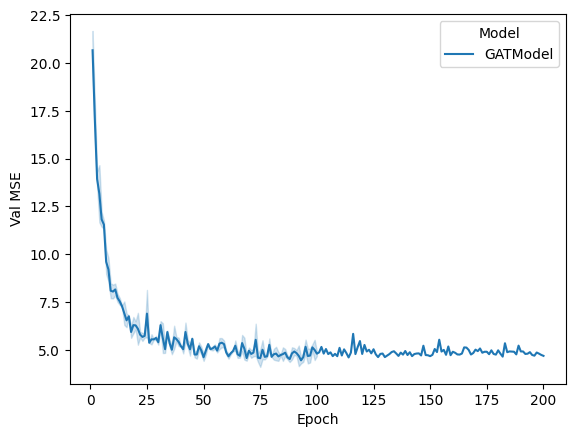

In [142]:
p = sns.lineplot(x="Epoch", y="Val MSE", hue="Model", data=DF_RESULTS)
#p.set(ylim=(0, 2));

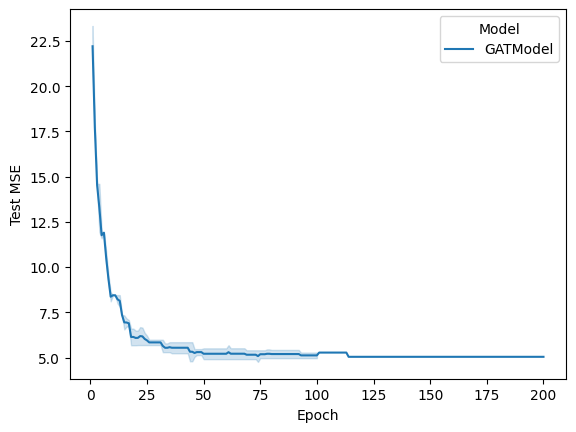

In [143]:
p = sns.lineplot(x="Epoch", y="Test MSE", hue="Model", data=DF_RESULTS)
#p.set(ylim=(0, 1));

Obtain predictions for test set

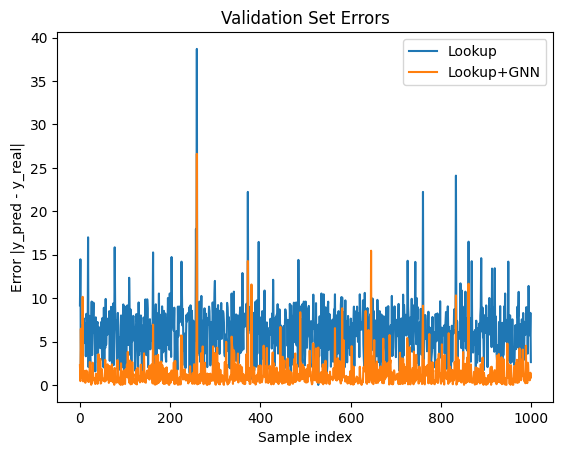

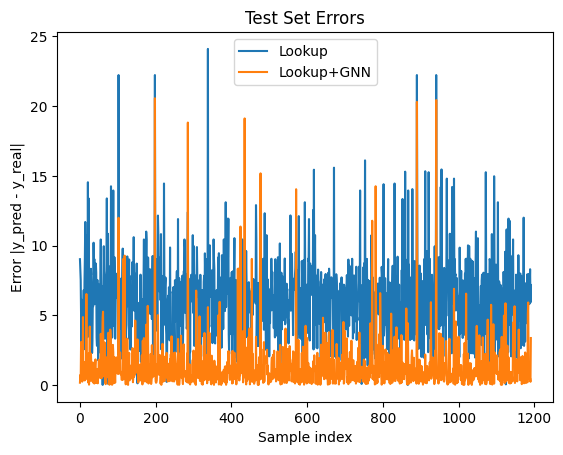

In [144]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Ensure model is in eval mode and on CPU
model.eval()
model.to('cpu')

# Compute validation set errors
val_errors_lookup = []
val_errors_gnn = []
for data in val_loader:
    data = data.to('cpu')
    with torch.no_grad():
        y_res = model(data)  # predicted residual
    y_res = y_res.cpu().numpy()
    y0 = data.y0.cpu().numpy()             # lookup baseline
    y_true = (data.y + data.y0).cpu().numpy()  # actual energy
    # error = y_pred - y_true
    val_errors_gnn.extend(np.abs((y_res + y0) - y_true))
    val_errors_lookup.extend(np.abs(y0 - y_true))

# Compute test set errors
test_errors_lookup = []
test_errors_gnn = []
for data in test_loader:
    data = data.to('cpu')
    with torch.no_grad():
        y_res = model(data)
    y_res = y_res.cpu().numpy()
    y0 = data.y0.cpu().numpy()
    y_true = (data.y + data.y0).cpu().numpy()
    test_errors_gnn.extend(np.abs((y_res + y0) - y_true))
    test_errors_lookup.extend(np.abs(y0 - y_true))

# Plot Validation errors
plt.figure()
plt.plot(range(len(val_errors_lookup)), val_errors_lookup, label='Lookup')
plt.plot(range(len(val_errors_gnn)), val_errors_gnn, label='Lookup+GNN')
plt.xlabel('Sample index')
plt.ylabel('Error |y_pred - y_real|')
plt.legend()
plt.title('Validation Set Errors')
plt.show()

# Plot Test errors
plt.figure()
plt.plot(range(len(test_errors_lookup)), test_errors_lookup, label='Lookup')
plt.plot(range(len(test_errors_gnn)), test_errors_gnn, label='Lookup+GNN')
plt.xlabel('Sample index')
plt.ylabel('Error |y_pred - y_real|')
plt.legend()
plt.title('Test Set Errors')
plt.show()


In [145]:
np.mean(test_errors_gnn)

1.3537346

In [146]:
np.mean(test_errors_lookup)

6.239156

In [147]:
np.mean(val_errors_gnn)

1.3138808

In [148]:
np.mean(val_errors_lookup)

6.2243967